# gpOptimizer: Single-Task Acquisition Functions

In [1]:
#!pip install gpcam==8.1.3

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time
from loguru import logger

%load_ext autoreload
%autoreload 2


In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data Preparation

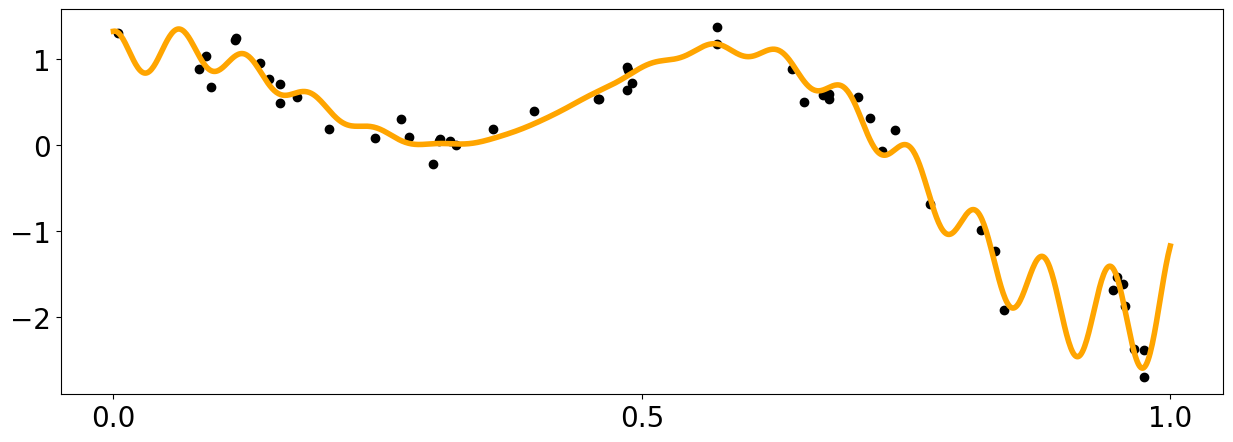

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
 
x_data = np.random.rand(50).reshape(-1,1) 
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing the Gaussian Process

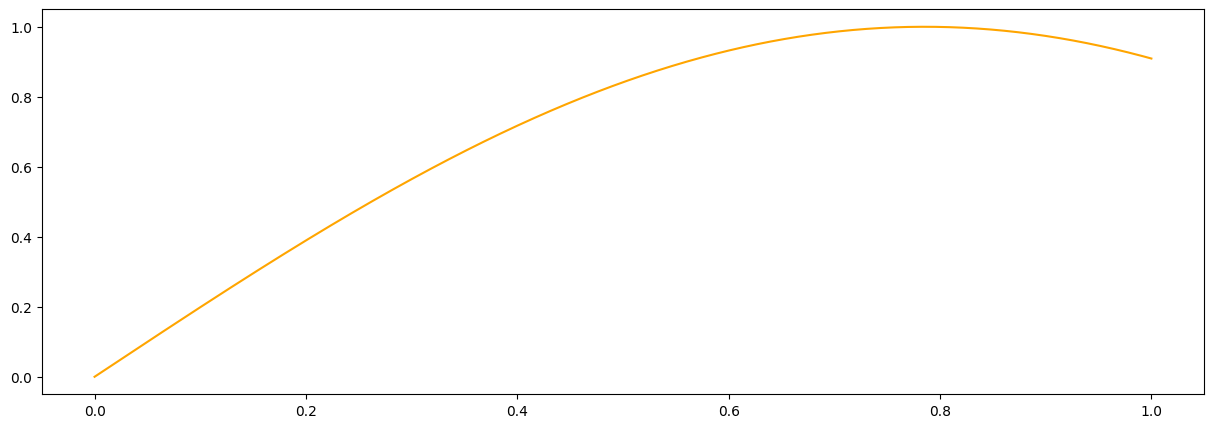

In [5]:
def my_noise(x,hps):
    #This is a simple noise function but can be made arbitrarily complex using many hyperparameters.
    #The noise function always has to return a matrix, because the noise can have covariances.
    return np.diag(np.zeros((len(x))) + hps[2])

#stationary
from gpcam.gp_kernels import *
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This is a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

## Initialization and Different Training Options

In [6]:


my_gpo = GPOptimizer(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # We need enough of those for kernel, noise, and prior mean functions 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args={'a': 1.5, 'b':2.},
            )

hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,0.1],  #noise
                       [0.001,1.]  #mean
                      ])
my_gpo.tell(x_data, y_data, append=False)
my_gpo.tell(x_data, y_data, append=True)
my_gpo.tell(x_data, y_data)
print("Standard Training")
my_gpo.train(hyperparameter_bounds=hps_bounds)
print("Global Training")
my_gpo.train(hyperparameter_bounds=hps_bounds, method='global')
print("hps: ", my_gpo.get_hyperparameters())
print("Local Training")
my_gpo.train(hyperparameter_bounds=hps_bounds, method='local')
print(my_gpo.get_hyperparameters())
print("MCMC Training")
my_gpo.train(hyperparameter_bounds=hps_bounds, method='mcmc', max_iter=1000)
print("HGDL Training")
my_gpo.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=10)


Standard Training
Global Training
hps:  [1.81285128e+00 1.69403990e-01 2.86629927e-02 1.03449876e-03]
Local Training
[9.47248754 0.34527168 0.03040518 0.02341244]
MCMC Training


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/fvgp/gp_training.py:331: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  OptimumEvaluation = minimize(


HGDL Training


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


array([9.65403248e+00, 4.43671013e-01, 3.74551554e-02, 9.22989421e-03])

## Asynchronous Training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [7]:
opt_obj = my_gpo.train_async(hyperparameter_bounds=hps_bounds)
for i in range(10):
    my_gpo.update_hyperparameters(opt_obj)
    time.sleep(2)
    print(my_gpo.hyperparameters)
    print("")

my_gpo.stop_training(opt_obj)

/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/fvgp/gp_training.py:243: UserWarning:      Hyperparameter update failed
  warnings.warn("     Hyperparameter update failed")
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


[9.65403248e+00 4.43671013e-01 3.74551554e-02 9.22989421e-03]

[8.64299685 0.41433602 0.03634774 0.16228765]

[8.64299685 0.41433602 0.03634774 0.16228765]

[8.64299685 0.41433602 0.03634774 0.16228765]

[8.64299685 0.41433602 0.03634774 0.16228765]

[8.64299685 0.41433602 0.03634774 0.16228765]

[8.64299685 0.41433602 0.03634774 0.16228765]

[8.64299685 0.41433602 0.03634774 0.16228765]

[8.64299685 0.41433602 0.03634774 0.16228765]

[8.64299685 0.41433602 0.03634774 0.16228765]



## Calculating on Vizualizing the Results

0.23846436145294597
(1.086254102648619, 0.9399689910073239)


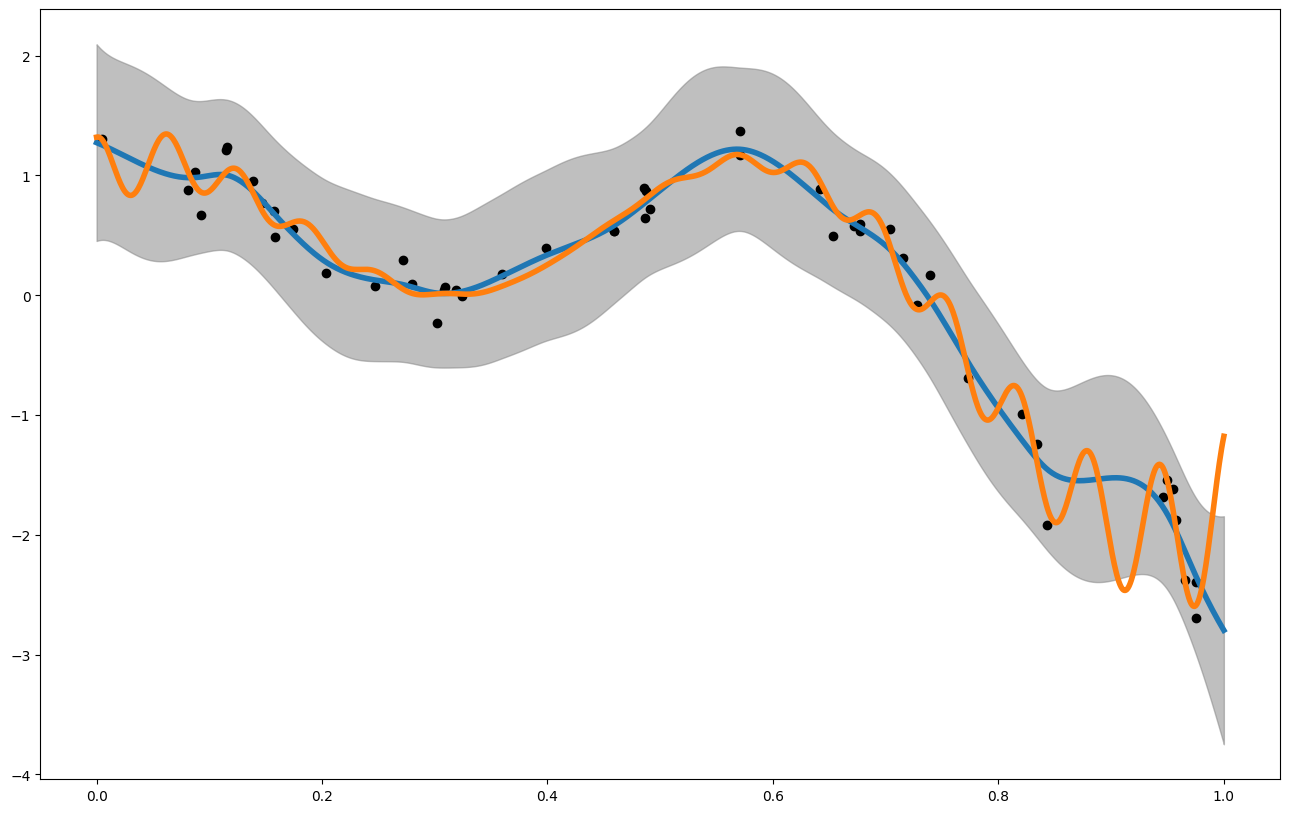

In [8]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gpo.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gpo.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gpo.rmse(x_pred1D,f1(x_pred1D)))
print(my_gpo.crps(x_pred1D,f1(x_pred1D)))

In [9]:
#available acquisition function:
acquisition_functions = ["variance","relative information entropy","relative information entropy set",
                        "ucb","lcb","maximum","minimum","gradient","expected improvement",
                         "probability of improvement", "target probability", "total correlation"]

Acquisition function  variance
 creates an output of shape (1000,)
Acquisition function  relative information entropy
 creates an output of shape (1,)
Some acquisition function return a scalar score for the entirety of points. Here:  relative information entropy
Acquisition function  relative information entropy set
 creates an output of shape (1000,)
Acquisition function  ucb
 creates an output of shape (1000,)
Acquisition function  lcb
 creates an output of shape (1000,)
Acquisition function  maximum
 creates an output of shape (1000,)
Acquisition function  minimum
 creates an output of shape (1000,)
Acquisition function  gradient
 creates an output of shape (1000,)
Acquisition function  expected improvement
 creates an output of shape (1000,)
Acquisition function  probability of improvement
 creates an output of shape (1000,)
Acquisition function  target probability
 creates an output of shape (1000,)
Acquisition function  total correlation
 creates an output of shape (1,)
Some acqu

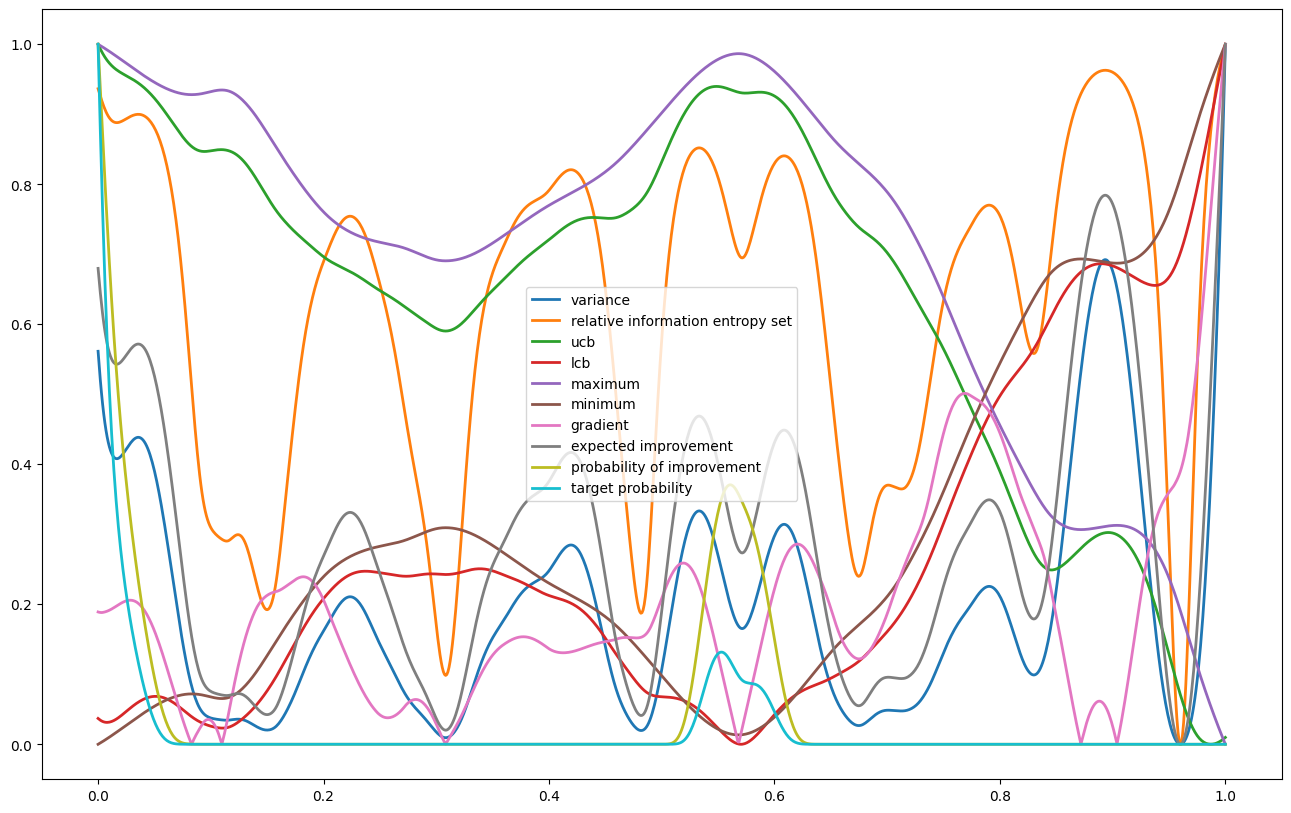

In [10]:
plt.figure(figsize=(16,10))
for acq_func in acquisition_functions:
    print("Acquisition function ",acq_func)
    res = my_gpo.evaluate_acquisition_function(x_pred, acquisition_function=acq_func)
    print(" creates an output of shape",res.shape)
    if len(res)==len(x_pred):
        res = res - np.min(res)
        res = res/np.max(res)
        plt.plot(x_pred,res, label = acq_func, linewidth = 2)
    else: print("Some acquisition function return a scalar score for the entirety of points. Here: ", acq_func)
plt.legend()
plt.show()


## ask()ing for Optimal Evaluations
with several optimization methods and acquisition functions

In [11]:
#let's test the asks:
bounds = np.array([[0.0,1.0]])
for acq_func in acquisition_functions:
    for method in ["global","local","hgdl"]:
        print("Acquisition function ", acq_func," and method ",method)
        new_suggestion = my_gpo.ask(bounds, acquisition_function=acq_func, 
                                    method=method, max_iter = 2,)
        print("led to new suggestion: \n", new_suggestion)
        print("")


Acquisition function  variance  and method  global
led to new suggestion: 
 {'x': array([[0.01165198]]), 'f(x)': array([0.03008112]), 'opt_obj': None}

Acquisition function  variance  and method  local
led to new suggestion: 
 {'x': array([[0.55822749]]), 'f(x)': array([0.01822102]), 'opt_obj': None}

Acquisition function  variance  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41441 instead
  warnings.warn(


led to new suggestion: 
 {'x': array([[0.89345446]]), 'f(x)': array([0.04624862]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f50e3a45720>}

Acquisition function  relative information entropy  and method  global
led to new suggestion: 
 {'x': array([[0.99903901]]), 'f(x)': array([-67.991209]), 'opt_obj': None}

Acquisition function  relative information entropy  and method  local
led to new suggestion: 
 {'x': array([[0.]]), 'f(x)': array([-108.85626715]), 'opt_obj': None}

Acquisition function  relative information entropy  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[1.]]), 'f(x)': array([-64.24755875]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f50e3b4ec20>}

Acquisition function  relative information entropy set  and method  global
led to new suggestion: 
 {'x': array([[0.88053605]]), 'f(x)': array([-98.11030345]), 'opt_obj': None}

Acquisition function  relative information entropy set  and method  local
led to new suggestion: 
 {'x': array([[0.]]), 'f(x)': array([-108.85626715]), 'opt_obj': None}

Acquisition function  relative information entropy set  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[1.]]), 'f(x)': array([-64.24755875]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f50c8621090>}

Acquisition function  ucb  and method  global
led to new suggestion: 
 {'x': array([[0.00016411]]), 'f(x)': array([1.86116143]), 'opt_obj': None}

Acquisition function  ucb  and method  local
led to new suggestion: 
 {'x': array([[0.50523231]]), 'f(x)': array([1.28026703]), 'opt_obj': None}

Acquisition function  ucb  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.43901671]]), 'f(x)': array([0.88925848]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f50c85119f0>}

Acquisition function  lcb  and method  global
led to new suggestion: 
 {'x': array([[0.99223527]]), 'f(x)': array([3.26851655]), 'opt_obj': None}

Acquisition function  lcb  and method  local
led to new suggestion: 
 {'x': array([[1.]]), 'f(x)': array([3.55732899]), 'opt_obj': None}

Acquisition function  lcb  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.23722628]]), 'f(x)': array([0.24133951]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f50c8596800>}

Acquisition function  maximum  and method  global
led to new suggestion: 
 {'x': array([[0.56266575]]), 'f(x)': array([1.21661789]), 'opt_obj': None}

Acquisition function  maximum  and method  local
led to new suggestion: 
 {'x': array([[0.]]), 'f(x)': array([1.27432824]), 'opt_obj': None}

Acquisition function  maximum  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.]]), 'f(x)': array([1.27432824]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f50c84c2e30>}

Acquisition function  minimum  and method  global
led to new suggestion: 
 {'x': array([[0.99821298]]), 'f(x)': array([2.76799813]), 'opt_obj': None}

Acquisition function  minimum  and method  local
led to new suggestion: 
 {'x': array([[0.48649461]]), 'f(x)': array([-0.77255472]), 'opt_obj': None}

Acquisition function  minimum  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.30833403]]), 'f(x)': array([-0.01490009]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f50c8205090>}

Acquisition function  gradient  and method  global
led to new suggestion: 
 {'x': array([[0.99780624]]), 'f(x)': array([3.86140905]), 'opt_obj': None}

Acquisition function  gradient  and method  local
led to new suggestion: 
 {'x': array([[0.]]), 'f(x)': array([0.75813144]), 'opt_obj': None}

Acquisition function  gradient  and method  hgdl
led to new suggestion: 
 {'x': array([[0.76894567]]), 'f(x)': array([2.00978593]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f50c8205300>}

Acquisition function  expected improvement  and method  global
led to new suggestion: 
 {'x': array([[0.8897881]]), 'f(x)': array([0.08551725]), 'opt_obj': None}

Acquisition function  expected improvement  and method  local
led to new suggestion: 
 {'x': array([[1.]]), 'f(x)': array([0.10116941]), 'opt_obj': None}

Acquisition function  expected improvement  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.4195105]]), 'f(x)': array([0.05959882]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f50c8107d00>}

Acquisition function  probability of improvement  and method  global
led to new suggestion: 
 {'x': array([[0.57659367]]), 'f(x)': array([0.10068377]), 'opt_obj': None}

Acquisition function  probability of improvement  and method  local
led to new suggestion: 
 {'x': array([[0.82519028]]), 'f(x)': array([9.20019863e-131]), 'opt_obj': None}

Acquisition function  probability of improvement  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.56079663]]), 'f(x)': array([0.11444966]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f50a47cf790>}

Acquisition function  target probability  and method  global
led to new suggestion: 
 {'x': array([[3.93144994e-05]]), 'f(x)': array([-0.25026824]), 'opt_obj': None}

Acquisition function  target probability  and method  local
led to new suggestion: 
 {'x': array([[0.90500151]]), 'f(x)': array([-0.5]), 'opt_obj': None}

Acquisition function  target probability  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  r = 1. / np.min(eig)


led to new suggestion: 
 {'x': array([[0.55296622]]), 'f(x)': array([-0.46702877]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f50a46eafe0>}

Acquisition function  total correlation  and method  global
led to new suggestion: 
 {'x': array([[0.89466667]]), 'f(x)': array([-3.15895423]), 'opt_obj': None}

Acquisition function  total correlation  and method  local
led to new suggestion: 
 {'x': array([[1.]]), 'f(x)': array([-3.3489466]), 'opt_obj': None}

Acquisition function  total correlation  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35729 instead
  warnings.warn(


led to new suggestion: 
 {'x': array([[1.]]), 'f(x)': array([-3.3489466]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f50a46eb6d0>}



/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


In [12]:
#here we can test other options of the ask() command
bounds = np.array([[0.0,1.0]])
new_suggestion = my_gpo.ask(bounds, acquisition_function="total_correlation", method="global",
                            max_iter=10, n = 5, info = True)
my_gpo.ask(bounds, n = 5, acquisition_function="variance", vectorized=True, method = 'global')
my_gpo.ask(bounds, n = 1, acquisition_function="relative information entropy", vectorized=True, method = 'global')
my_gpo.ask(bounds, n = 2, acquisition_function="expected improvement", vectorized=True, method = 'global')
my_gpo.ask(bounds, n = 1, acquisition_function="variance", vectorized=True, method = 'global')
my_gpo.ask(bounds, n = 3, acquisition_function="variance", vectorized=True, method = 'hgdl')
print(new_suggestion)

/home/marcus/Coding/gpCAM/gpcam/gp_optimizer.py:805: UserWarning: You specified n>1 and method != 'hgdl' in ask(). The acquisition function has therefore been changed to 'total correlation'
  warnings.warn("You specified n>1 and method != 'hgdl' in ask(). The acquisition function "


differential_evolution step 1: f(x)= 19.522389900739796
differential_evolution step 2: f(x)= 19.522389900739796
differential_evolution step 3: f(x)= 18.431637800623776
differential_evolution step 4: f(x)= 18.431637800623776
differential_evolution step 5: f(x)= 18.431637800623776
differential_evolution step 6: f(x)= 18.431637800623776
differential_evolution step 7: f(x)= 18.431637800623776
differential_evolution step 8: f(x)= 18.431637800623776
differential_evolution step 9: f(x)= 18.431637800623776
differential_evolution step 10: f(x)= 18.431637800623776


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38123 instead
  warnings.warn(
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, m

{'x': array([[0.91439841],
       [0.62188648],
       [0.04191555],
       [0.51622989],
       [0.89827201]]), 'f(x)': array([-18.4316378]), 'opt_obj': None}


In [13]:
#We can also ask for the best subset of a candidate set

In [14]:
my_gpo.ask([np.array([1.]),np.array([2.])], n = 3, acquisition_function="variance", vectorized=True, method = 'hgdl')

{'x': array([[2.],
        [1.]]),
 'f(x)': array([8.57723377, 0.06430997]),
 'opt_obj': None}

In [15]:
bounds = np.array([[0.0,1.0]])

#You can even start an ask() search asynchronously and check back later what was found
new_suggestion = my_gpo.ask(bounds, acquisition_function=acquisition_functions[0], method="hgdlAsync")
time.sleep(10)
print(new_suggestion["opt_obj"])
#And we have to cancel that trainig and possibly kill the client
new_suggestion["opt_obj"].kill_client()

/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42431 instead
  warnings.warn(
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, m

[{'x': array([0.53322329]),
  'f(x)': -0.02517686125924712,
  'classifier': 'minimum',
  'Hessian eigvals': array([31.44151606]),
  'df/dx': array([6.50146603e-07]),
  '|df/dx|': 6.501466032204917e-07,
  'radius': 0.03180508211419842},
 {'x': array([0.60857834]),
  'f(x)': -0.024052491770740758,
  'classifier': 'minimum',
  'Hessian eigvals': array([27.90478959]),
  'df/dx': array([-2.87769808e-07]),
  '|df/dx|': 2.877698079828406e-07,
  'radius': 0.035836141920002035},
 {'x': array([0.41951154]),
  'f(x)': -0.0223179965670397,
  'classifier': 'minimum',
  'Hessian eigvals': array([19.10827052]),
  'df/dx': array([2.16768825e-05]),
  '|df/dx|': 2.1676882511201256e-05,
  'radius': 0.052333359990825695}]

2024-06-26 17:14:43,237 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43117'.
2024-06-26 17:14:43,239 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:43117'. Shutting down.
2024-06-26 17:14:43,239 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:45899'.
2024-06-26 17:14:43,241 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:45899'. Shutting down.
2024-06-26 17:14:43,283 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:45701'.
2024-06-26 17:14:43,283 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:45701'. Shutting down.
2024-06-26 17:14:43,284 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:45243'.
2024-06-26 17:14:43,285 - distributed.scheduler - WARNING - Received heartbeat from unre